# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialise GPU

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading and Pre-processing

In [ ]:
# Class for pre-processing the data
class MIMICDataProcessor:
    def __init__(self, file_path, batch_size=64):
        self.file_path = file_path
        self.batch_size = batch_size
        self.scaler = StandardScaler()

        # Load and preprocess the data
        self.df = pd.read_csv(file_path)
        # Replace all missing values with 0
        self.df.fillna(0, inplace=True)

        # Features
        self.X = self.df[['upper_respiratory_infections', 'influenza_pneumonia', 'acute_lower_respiratory_infections', 'chronic_lower_respiratory_diseases',
                          'lung_diseases_due_to_external_agents', 'other_respiratory_diseases', 'InvasiveVent', 'SupplementalOxygen', 'HFNC',
                          'NonInvasiveVent', 'Tracheostomy', 'None', 'avg_uo_24hr', 'avg_creatinine_max', 'max_renal_uo_24hr', 'max_renal_creatinine_max',
                          'avg_pao2fio2ratio_novent', 'avg_pao2fio2ratio_vent', 'max_respiration_pao2fio2ratio_novent', 'max_respiration_pao2fio2ratio_vent', 'avg_gcs_min', 'max_cns_gcs_min',
                          'sofa_score', 'suspected_infection', 'one_vasopressor', 'multi_vasopressor']]

        # Concepts
        self.C = self.df[['c_rsp_mod', 'c_rsp_svr', 'c_vent_low', 'c_vent_moderate', 'c_vent_high', 'c_max_renf_moderate', 'c_max_renf_severe',
                          'c_avg_renf_moderate', 'c_avg_renf_severe', 'c_max_respf_moderate', 'c_max_respf_severe', 'c_avg_respf_moderate',
                          'c_avg_respf_severe', 'c_max_cnsf_moderate', 'c_max_cnsf_severe', 'c_avg_cnsf_moderate', 'c_avg_cnsf_severe',
                          'c_sepsis3', 'c_shock']]

        # Label
        self.Y = self.df['ARDS']

        # Convert to tensors
        self.X_tensor = torch.tensor(self.X.values, dtype=torch.float32)
        self.C_tensor = torch.tensor(self.C.values, dtype=torch.float32)
        self.Y_tensor = torch.tensor(self.Y.values, dtype=torch.float32)

        # Normalize the features
        self.X_scaled = self.scaler.fit_transform(self.X)
        self.X_tensor_scaled = torch.tensor(self.X_scaled, dtype=torch.float32)

    def get_features(self):
        return self.X.columns.tolist()

    def get_concepts(self):
        return self.C.columns.tolist()

    def get_labels(self):
        return self.Y.columns.tolist()

    # Dataset class needed to provide the __getitem__ method for DataLoader
    class MIMICDataset(Dataset):
        def __init__(self, x, c, y):
            self.x = x
            self.c = c
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.x[idx], self.c[idx], self.y[idx]

    def create_dataloaders(self):
        # Split the data into temporary (80%) and test (20%) sets
        X_temp, X_test, C_temp, C_test, Y_temp, Y_test = train_test_split(
            self.X_tensor_scaled, self.C_tensor, self.Y_tensor, test_size=0.20, random_state=42)

        # Further split the temporary data into training (75% of temporary) and validation (25% of temporary) sets
        X_train, X_val, C_train, C_val, Y_train, Y_val = train_test_split(
            X_temp, C_temp, Y_temp, test_size=0.25, random_state=42)

        train_dataset = self.MIMICDataset(X_train, C_train, Y_train)
        val_dataset = self.MIMICDataset(X_val, C_val, Y_val)
        test_dataset = self.MIMICDataset(X_test, C_test, Y_test)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

# Model

In [ ]:
class MultiLabelNN(nn.Module):
    def __init__(self, num_features, num_concepts, num_labels):
        super(MultiLabelNN, self).__init__()
        # Layers to predict concepts
        self.layer1 = nn.Linear(num_features, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 64)
        self.concept_output_layer = nn.Linear(64, num_concepts)

        # Layers to predict final output from concepts
        self.layer5 = nn.Linear(num_concepts, 64)
        self.layer6 = nn.Linear(64, 128)
        self.layer7 = nn.Linear(128, 64)
        self.label_output_layer = nn.Linear(64, num_labels)

    def forward(self, x):
        # Layers for concept prediction
        x_c = torch.relu(self.layer1(x))
        x_c = torch.relu(self.layer2(x_c))
        x_c = torch.relu(self.layer3(x_c))
        intermediate_output = self.concept_output_layer(x_c)
        intermediate_probability = torch.sigmoid(intermediate_output)

        # Layers for label prediction
        x = torch.relu(intermediate_output)
        x = torch.relu(self.layer5(x))
        x = torch.relu(self.layer6(x))
        x = torch.relu(self.layer7(x))
        final_probability = torch.sigmoid(self.label_output_layer(x))

        return intermediate_probability, final_probability

# Training

Look at the Step 5 from this [basic code](https://colab.research.google.com/drive/1LqE89tPVt6h1wa7lerLgF4GNvRw9QFDw?usp=sharing) for reference.

In [ ]:
def train(x_size, c_size, y_size, x_to_y_learning_rate, lamda, epochs, train_loader, val_loader):
    torch.manual_seed(25)

    x_to_y = MultiLabelNN(num_features=x_size, num_concepts=c_size, num_labels=y_size).to(device)

    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification
    x_to_y_optimizer = torch.optim.Adam(x_to_y.parameters(), lr=x_to_y_learning_rate)

    epochs_count = []
    x_to_c_loss_values, c_to_y_loss_values, total_loss_values = [], [], []
    x_to_c_predictions, c_to_y_predictions = [], []
    x_to_c_val_loss_values, c_to_y_val_loss_values, total_val_loss_values = [], [], []
    x_to_c_val_predictions, c_to_y_val_predictions = [], []
    ground_truth_val_c, ground_truth_val_y = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        x_to_y.train()

        running_x_to_c_loss, running_c_to_y_loss = 0.0, 0.0
        running_total_loss = 0.0
        total_samples = 0

        for i, batch in enumerate(train_loader):
            x, c, y = batch
            x, c, y = x.to(device), c.to(device), y.to(device)

            # Forward pass through x_to_y
            x_to_y_optimizer.zero_grad()
            x = x.to(x_to_y.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
            predicted_c, predicted_y = x_to_y(x)

            # Squeeze the predictions to match the target dimensions
            predicted_c = predicted_c.squeeze()
            predicted_y = predicted_y.squeeze()

            x_to_c_predictions.append(predicted_c.detach().cpu().numpy())
            c_to_y_predictions.append(predicted_y.detach().cpu().numpy())

            c_loss = criterion(predicted_c, c.float())
            y_loss = criterion(predicted_y, y.float())

            # Combined loss
            total_loss = c_loss + lamda * y_loss

            # Backward pass and optimisation for combined loss
            total_loss.backward()
            x_to_y_optimizer.step()

            # Accumulate loss values
            running_x_to_c_loss += c_loss.item()
            running_c_to_y_loss += y_loss.item()
            running_total_loss += total_loss.item()

            total_samples += len(y)

        x_to_c_loss_values.append(running_x_to_c_loss / len(train_loader))
        c_to_y_loss_values.append(running_c_to_y_loss / len(train_loader))
        total_loss_values.append(running_total_loss / len(train_loader))

        # valing Loop
        x_to_y.eval()

        running_x_to_c_val_loss, running_c_to_y_val_loss = 0.0, 0.0
        running_total_val_loss = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for x, c, y in val_loader:
                # GPU
                x, c, y = x.to(device), c.to(device), y.to(device)

                # Ground truth array
                ground_truth_val_c.append(c.cpu())
                ground_truth_val_y.append(y.cpu())

                # Forward pass through x_to_y
                x = x.to(x_to_y.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
                predicted_c, predicted_y = x_to_y(x)

                # Squeeze the predictions to match the target dimensions
                predicted_c = predicted_c.squeeze()
                predicted_y = predicted_y.squeeze()

                x_to_c_val_predictions.append(predicted_c.detach().cpu().numpy())
                c_to_y_val_predictions.append(predicted_y.detach().cpu().numpy())

                c_loss = criterion(predicted_c, c.float())
                y_loss = criterion(predicted_y, y.float())

                total_loss = c_loss + lamda * y_loss

                # Accumulate loss values for valing
                running_x_to_c_val_loss += c_loss.item()
                running_c_to_y_val_loss += y_loss.item()
                running_total_val_loss += total_loss.item()

                total_val_samples += len(y)

        x_to_c_val_loss_values.append(running_x_to_c_val_loss / len(val_loader))
        c_to_y_val_loss_values.append(running_c_to_y_val_loss / len(val_loader))
        total_val_loss_values.append(running_total_val_loss / len(val_loader))

    return (x_to_y, epochs_count, x_to_c_loss_values, c_to_y_loss_values, total_loss_values, x_to_c_predictions, c_to_y_predictions, x_to_c_val_loss_values, c_to_y_val_loss_values, total_val_loss_values, x_to_c_val_predictions, c_to_y_val_predictions, ground_truth_val_c, ground_truth_val_y)

In [ ]:
# Specify Parameters
x_size = 26
c_size = 19
y_size = 1
x_to_y_learning_rate = 0.01
lamda = 0.3
epochs = 60

# Load Data
file_path = '/content/ards6-total.csv'
data_processor = MIMICDataProcessor(file_path, batch_size=64)
train_loader, test_loader, val_loader = data_processor.create_dataloaders()

x_to_y, epochs_count, x_to_c_loss_values, c_to_y_loss_values, total_loss_values, x_to_c_predictions, c_to_y_predictions, x_to_c_val_loss_values, c_to_y_val_loss_values, total_val_loss_values, x_to_c_val_predictions, c_to_y_val_predictions, ground_truth_val_c, ground_truth_val_y = train(x_size, c_size, y_size, x_to_y_learning_rate, lamda, epochs, train_loader, val_loader)

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


# Plotting Loss

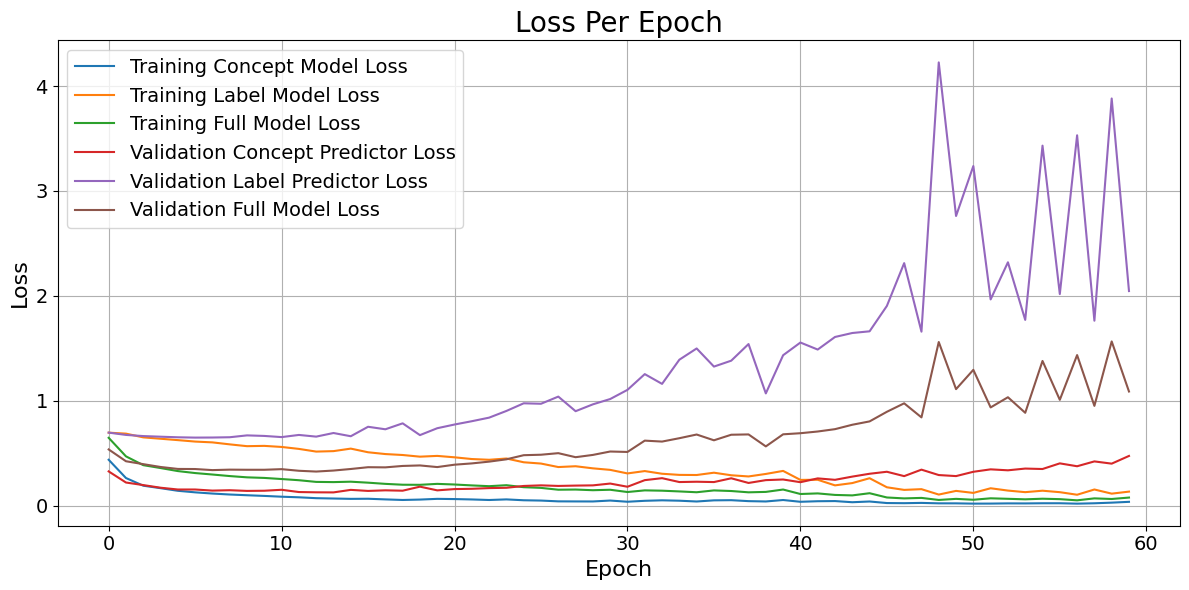

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Training Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Training Label Model Loss')
plt.plot(epochs_count, total_loss_values, label='Training Full Model Loss')
plt.plot(epochs_count, x_to_c_val_loss_values, label='Validation Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_val_loss_values, label='Validation Label Predictor Loss')
plt.plot(epochs_count, total_val_loss_values, label='Validation Full Model Loss')
plt.title('Loss Per Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('ards-joint-nft.png')
plt.show()

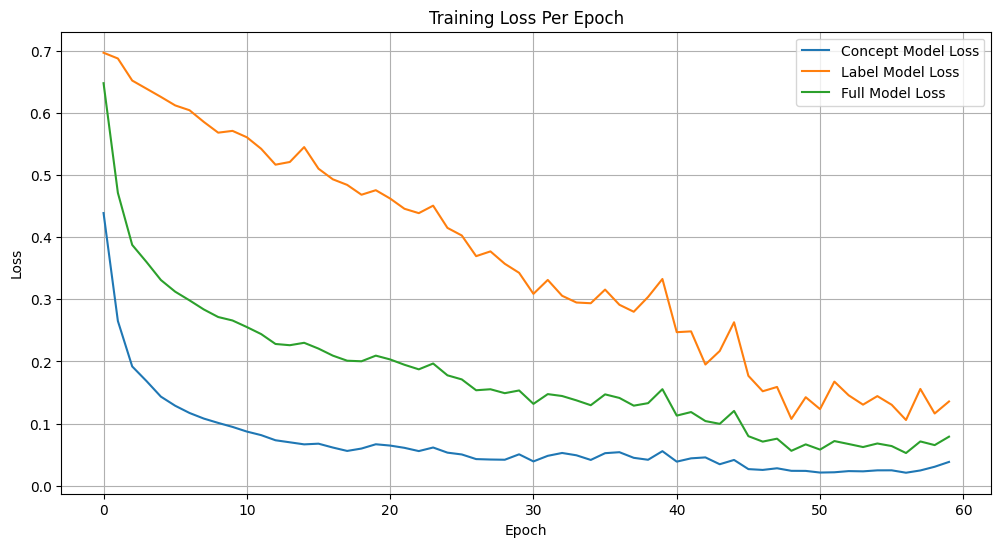

In [ ]:
# Training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Label Model Loss')
plt.plot(epochs_count, total_loss_values, label='Full Model Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

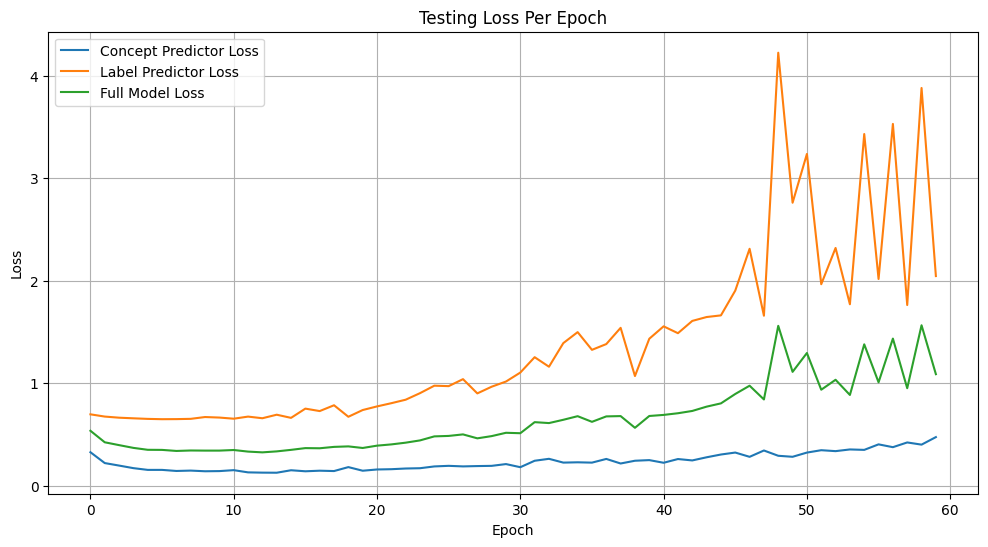

In [ ]:
# Testing loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_val_loss_values, label='Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_val_loss_values, label='Label Predictor Loss')
plt.plot(epochs_count, total_val_loss_values, label='Full Model Loss')
plt.title('Testing Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Validation Evaluation

In [ ]:
def evaluate_concept_predictor(ground_truth_c, x_to_c_predictions, concept_labels):
    results = []
    precisions = []
    recalls = []
    f1_scores = []
    aucs = []
    accuracies = []

    for i, label in enumerate(concept_labels):
        true_values = torch.cat([c[:, i] if isinstance(c, torch.Tensor) else torch.tensor(c[:, i]) for c in ground_truth_c]).numpy()
        predicted_values = torch.cat([c[:, i] if isinstance(c, torch.Tensor) else torch.tensor(c[:, i]) for c in x_to_c_predictions]).numpy()

        predicted_classes = (predicted_values > 0.5).astype(int)  # Convert probabilities to binary classes

        precision = precision_score(true_values, predicted_classes, zero_division=0)
        recall = recall_score(true_values, predicted_classes, zero_division=0)
        f1 = f1_score(true_values, predicted_classes, zero_division=0)
        # Check if both classes are present in true_values before calculating AUC
        if len(np.unique(true_values)) == 2:
            auc = roc_auc_score(true_values, predicted_classes)
        else:
            auc = None
        accuracy = accuracy_score(true_values, predicted_classes)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        aucs.append(auc if auc is not None else 0)  # Use 0 or another value for averaging
        accuracies.append(accuracy)

        results.append({
            "Label": label,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC": auc,
            "Accuracy": accuracy
        })

    # Calculate the average values for each metric, excluding None values for AUC
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)
    avg_auc = np.mean([auc for auc in aucs if auc is not None])
    avg_accuracy = np.mean(accuracies)

    # Append the average values to the results
    results.append({
        "Label": "Average",
        "Precision": avg_precision,
        "Recall": avg_recall,
        "F1 Score": avg_f1,
        "AUC": avg_auc,
        "Accuracy": avg_accuracy
    })

    return pd.DataFrame(results)

In [ ]:
# Get concept labels from the data processor
concept_labels = data_processor.get_concepts()

# Evaluation
concept_predictor_results = evaluate_concept_predictor(ground_truth_val_c, x_to_c_val_predictions, concept_labels)
print("Validation Concept Predictor Results:")
print(concept_predictor_results)

Validation Concept Predictor Results:
                   Label  Precision    Recall  F1 Score       AUC  Accuracy
0              c_rsp_mod   0.964651  0.975688  0.970138  0.934739  0.955062
1              c_rsp_svr   0.968287  0.943293  0.955626  0.967725  0.982263
2             c_vent_low   0.985948  0.988926  0.987435  0.974837  0.981481
3        c_vent_moderate   0.964490  0.938889  0.951517  0.966785  0.987243
4            c_vent_high   0.999586  0.998594  0.999090  0.957630  0.998189
5    c_max_renf_moderate   0.857995  0.810902  0.833784  0.872639  0.893827
6      c_max_renf_severe   0.921380  0.887928  0.904345  0.912108  0.914198
7    c_avg_renf_moderate   0.214953  0.164286  0.186235  0.559862  0.900741
8      c_avg_renf_severe   0.664417  0.689000  0.676485  0.819993  0.918642
9   c_max_respf_moderate   0.679125  0.620833  0.648672  0.802798  0.966790
10    c_max_respf_severe   0.980084  0.984199  0.982137  0.799600  0.965967
11  c_avg_respf_moderate   0.713351  0.749141  0.7

In [ ]:
# Label Predictor Evaluation
def evaluate_label_predictor(ground_truth_y, c_to_y_predictions):
    # Ensure all elements are tensors
    ground_truth_y = [torch.tensor(gy) if not isinstance(gy, torch.Tensor) else gy for gy in ground_truth_y]
    c_to_y_predictions = [torch.tensor(py) if not isinstance(py, torch.Tensor) else py for py in c_to_y_predictions]

    true_values = torch.cat(ground_truth_y).numpy()
    predicted_values = torch.cat(c_to_y_predictions).squeeze().numpy()

    predicted_classes = (predicted_values > 0.5).astype(int)  # Convert probabilities to binary classes

    precision = precision_score(true_values, predicted_classes)
    recall = recall_score(true_values, predicted_classes)
    f1 = f1_score(true_values, predicted_classes)
    auc = roc_auc_score(true_values, predicted_classes)
    accuracy = accuracy_score(true_values, predicted_classes)

    results = {"Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy}

    index = pd.Index(["Metrics"])
    return pd.DataFrame(results, index=index)

In [ ]:
# Evaluation
print("Validation Label Predictor Results:")
label_predictor_results = evaluate_label_predictor(ground_truth_val_y, c_to_y_val_predictions)
print(label_predictor_results)

Validation Label Predictor Results:
         Precision    Recall  F1 Score       AUC  Accuracy
Metrics   0.639877  0.579665  0.608285  0.615895  0.614733


# Testing Evaluation

In [ ]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification

    running_x_to_c_test_loss, running_c_to_y_test_loss = 0.0, 0.0
    running_total_test_loss = 0.0
    total_test_samples = 0
    ground_truth_test_c, ground_truth_test_y = [], []
    x_to_c_test_predictions, c_to_y_test_predictions = [], []

    with torch.no_grad():
        for x, c, y in test_loader:
            # GPU
            x, c, y = x.to(device), c.to(device), y.to(device)

            # Ground truth array
            ground_truth_test_c.append(c.cpu())
            ground_truth_test_y.append(y.cpu())

            # Forward pass through the model
            x = x.to(model.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
            predicted_c, predicted_y = model(x)

            # Squeeze the predictions to match the target dimensions
            predicted_c = predicted_c.squeeze()
            predicted_y = predicted_y.squeeze()

            x_to_c_test_predictions.append(predicted_c.detach().cpu().numpy())
            c_to_y_test_predictions.append(predicted_y.detach().cpu().numpy())

            c_loss = criterion(predicted_c, c.float())
            y_loss = criterion(predicted_y, y.float())

            total_loss = c_loss + y_loss

            # Accumulate loss values for testing
            running_x_to_c_test_loss += c_loss.item()
            running_c_to_y_test_loss += y_loss.item()
            running_total_test_loss += total_loss.item()

            total_test_samples += len(y)

    print(f'Test Concept Predictor Loss: {running_x_to_c_test_loss / len(test_loader):.4f}')
    print(f'Test Label Predictor Loss: {running_c_to_y_test_loss / len(test_loader):.4f}')
    print(f'Test Total Loss: {running_total_test_loss / len(test_loader):.4f}')

    return ground_truth_test_c, ground_truth_test_y, x_to_c_test_predictions, c_to_y_test_predictions


In [ ]:
# Call the test function and print the results
ground_truth_test_c, ground_truth_test_y, x_to_c_test_predictions, c_to_y_test_predictions = test_model(x_to_y, test_loader)

Test Concept Predictor Loss: 0.3845
Test Label Predictor Loss: 2.5405
Test Total Loss: 2.9250


In [ ]:
# Evaluate and print test results for the concept predictor
concept_test_results = evaluate_concept_predictor(ground_truth_test_c, x_to_c_test_predictions, concept_labels)
print("Test Concept Predictor Results:")
print(concept_test_results)

Test Concept Predictor Results:
                   Label  Precision    Recall  F1 Score       AUC  Accuracy
0              c_rsp_mod   0.990196  0.968051  0.978998  0.967542  0.967822
1              c_rsp_svr   0.973333  0.960526  0.966887  0.977214  0.987624
2             c_vent_low   0.990196  0.977419  0.983766  0.972752  0.975248
3        c_vent_moderate   0.942308  0.924528  0.933333  0.957991  0.982673
4            c_vent_high   1.000000  1.000000  1.000000  1.000000  1.000000
5    c_max_renf_moderate   0.888000  0.834586  0.860465  0.891463  0.910891
6      c_max_renf_severe   0.930108  0.882653  0.905759  0.910077  0.910891
7    c_avg_renf_moderate   0.367347  0.409091  0.387097  0.661490  0.858911
8      c_avg_renf_severe   0.658537  0.482143  0.556701  0.720956  0.893564
9   c_max_respf_moderate   0.600000  0.176471  0.272727  0.585651  0.960396
10    c_max_respf_severe   0.979644  0.994832  0.987179  0.762122  0.975248
11  c_avg_respf_moderate   0.860465  0.666667  0.751269 

In [ ]:
# Evaluate and print test results for the label predictor
label_test_results = evaluate_label_predictor(ground_truth_test_y, c_to_y_test_predictions)
print("Test Label Predictor Results:")
print(label_test_results)

Test Label Predictor Results:
         Precision    Recall  F1 Score       AUC  Accuracy
Metrics   0.568075  0.654054   0.60804  0.616981  0.613861


# Model Weights

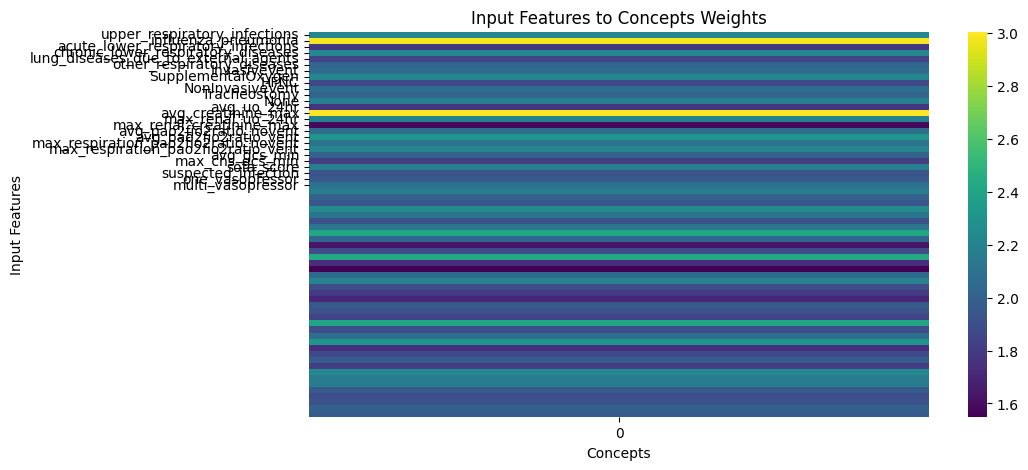

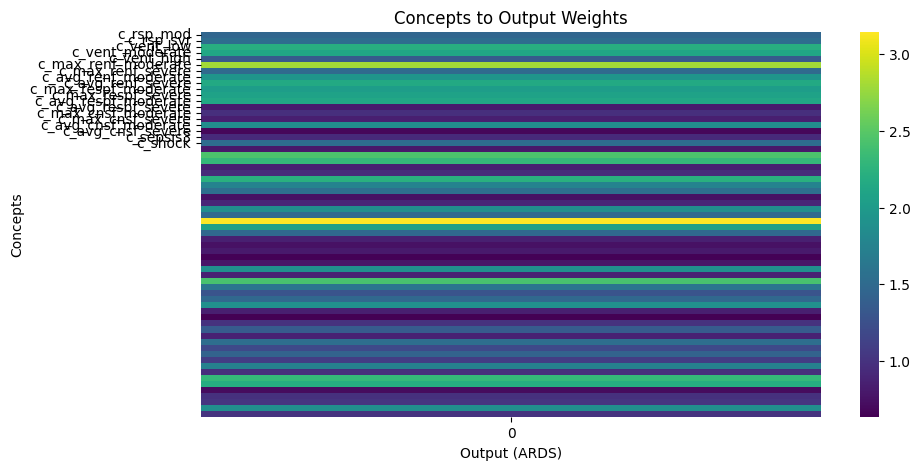

Normalized Weights from Input Features to Concepts:
upper_respiratory_infections: 2.2200138568878174
influenza_pneumonia: 2.984825372695923
acute_lower_respiratory_infections: 1.7918095588684082
chronic_lower_respiratory_diseases: 2.2244513034820557
lung_diseases_due_to_external_agents: 1.8440762758255005
other_respiratory_diseases: 2.0315909385681152
InvasiveVent: 2.0538854598999023
SupplementalOxygen: 2.224536180496216
HFNC: 1.866429090499878
NonInvasiveVent: 2.062776565551758
Tracheostomy: 2.0137670040130615
None: 2.1847963333129883
avg_uo_24hr: 1.7727195024490356
avg_creatinine_max: 3.0045371055603027
max_renal_uo_24hr: 2.1949386596679688
max_renal_creatinine_max: 1.5802273750305176
avg_pao2fio2ratio_novent: 2.0758962631225586
avg_pao2fio2ratio_vent: 2.3077452182769775
max_respiration_pao2fio2ratio_novent: 2.10164475440979
max_respiration_pao2fio2ratio_vent: 2.2054669857025146
avg_gcs_min: 2.0055384635925293
max_cns_gcs_min: 1.8104054927825928
sofa_score: 2.1744961738586426
suspect

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract weights from (input features to concepts)
input_to_concept_weights = x_to_y.layer1.weight.detach().cpu().numpy()

# Extract weights from (concepts to output)
concept_to_output_weights = x_to_y.layer5.weight.detach().cpu().numpy()

# Normalize the weights for better visualization
input_to_concept_weights_norm = np.linalg.norm(input_to_concept_weights, axis=1)
concept_to_output_weights_norm = np.linalg.norm(concept_to_output_weights, axis=1)

# Get feature and concept names
features = data_processor.get_features()
concepts = data_processor.get_concepts()

# Visualize input to concept weights
plt.figure(figsize=(10, 5))
sns.heatmap(input_to_concept_weights_norm.reshape(-1, 1), cmap="viridis", yticklabels=features)
plt.title("Input Features to Concepts Weights")
plt.xlabel("Concepts")
plt.ylabel("Input Features")
plt.show()

# Visualize concept to output weights
plt.figure(figsize=(10, 5))
sns.heatmap(concept_to_output_weights_norm.reshape(-1, 1), cmap="viridis", yticklabels=concepts)
plt.title("Concepts to Output Weights")
plt.xlabel("Output (ARDS)")
plt.ylabel("Concepts")
plt.show()

# Print the normalized weights
print("Normalized Weights from Input Features to Concepts:")
for feature, weight in zip(features, input_to_concept_weights_norm):
    print(f"{feature}: {weight}")

print("\nNormalized Weights from Concepts to Output (ARDS):")
for concept, weight in zip(concepts, concept_to_output_weights_norm):
    print(f"{concept}: {weight}")